In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('results.csv')
df.head()

,Price,Reviews,Rating,Brand,Operating System,CPU manufacturer,Screen size,Computer memory size,Processor count,Graphics Chipset Brand,...,Wireless communication technology,Human interface input,Connectivity Type,Graphics co-processor,Battery cell composition,Item dimensions L x W x H,Cellular technology,Other camera features,Software included,Wireless communication standard
0,£667.69,218 ratings,4.6 out of 5 stars,HUAWEI,Windows 10 Home,Intel,13 Inches,8 GB,8.0,NVIDIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,£399.99,98 ratings,3.8 out of 5 stars,TECLAST,Windows 10,Intel Celeron Processor N4100,11.6 Inches,8 GB,4.0,Intel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,£228.99,"2,586 ratings",4.0 out of 5 stars,ASUS,Windows 10 Home,Intel,14,4 GB,2.0,Intel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,£499.00,40 ratings,4.5 out of 5 stars,Dell,Windows 10,AMD,15.6 Inches,8 GB,1.0,AMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,£229.49,715 ratings,4.2 out of 5 stars,Jumper,Windows 10,Intel,13.3 Inches,4 GB,2.0,Intel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the data

First thing to notice is the columns with the large amount of NaNs

In [3]:
(df.isnull().sum()/df.shape[0])*100 

Price                                 0.000000
Reviews                               0.000000
Rating                                9.302326
Brand                                 0.000000
Operating System                      5.813953
CPU manufacturer                      3.488372
Screen size                           1.744186
Computer memory size                  0.581395
Processor count                       2.325581
Graphics Chipset Brand               19.476744
Series                               50.290698
CPU model                             4.069767
Colour                               77.906977
Hard disk size                       24.709302
Resolution                           49.418605
Item weight                          93.604651
Form Factor                          97.383721
Hard disk description                93.604651
Operating system                     95.058140
Graphics processor manufacturer      97.093023
Model name                           96.802326
RAM memory te

In [4]:
colsToDrop = df.columns[(df.isnull().sum()/df.shape[0])*100 > 40]
df = df.drop(colsToDrop,axis = 1)

In [5]:
df = df.replace(',','', regex=True)
df = df.replace('£','',regex = True)

df = df.replace('ratings','',regex = True)
df = df.replace('rating','',regex = True)
df = df.replace('out of 5 stars','',regex = True)

In [6]:
df['Operating System'].unique()

array(['Windows 10 Home', 'Windows 10', 'Windows', 'Windows 10 S',
       'Android 10', 'Windows 10 Pro', 'Chrome OS', nan, 'Android',
       'Mac OS X', 'Windows 7', 'Google Chrome'], dtype=object)

Obviously Google Chrome is not an operating system so we will change that to NaN. Secondly Android 10 is the most version of Android so it would make sense that when one defaults to Android it is the same as Android 10 so we will merge them. Windows 10 Home is the same as Windows 10. We will merge Windows 10 Home, Windows 10 and Windows 7 into Windows. 

In [7]:
df[df['Operating System'] == 'Windows 7']

,Price,Reviews,Rating,Brand,Operating System,CPU manufacturer,Screen size,Computer memory size,Processor count,Graphics Chipset Brand,CPU model,Hard disk size
296,299.99,61,4.2,X230,Windows 7,Intel,12.5 Inches,4 GB,1.0,NaN,Core i5,320 GB


In [8]:
df['Operating System'] = df['Operating System'].replace(['Windows 7','Windows 10','Windows 10 Home'],'Windows')
df['Operating System'] = df['Operating System'].replace('Android 10','Android')

In [9]:
df['CPU manufacturer'].unique()

array(['Intel', 'Intel Celeron Processor N4100', 'AMD', 'MediaTek',
       'Apple', nan, 'Intel Core i5-7300U', 'A33', 'VIA'], dtype=object)

In [10]:
df['CPU manufacturer'] = df['CPU manufacturer'].replace([ 'Intel Celeron Processor N4100','Intel Core i5-7300U'],'Intel')

In [11]:
df['Screen size'].unique()

array(['13 Inches', '11.6 Inches', '14', '15.6 Inches', '13.3 Inches',
       '14 Inches', '12.45 Inches', '10.1 Inches', '14.1 Inches',
       '17.3 Inches', '15.6', '15 Inches', nan, '10.1 Feet',
       '13.9 Inches', '12.5 Inches', '13.3', '35.6 Centimetres',
       '27 Inches', '17 Inches', '15.6 Centimetres', '15.4 Inches',
       '10 Inches', '6 Inches', '21.5 Inches', '11 Inches', '13.5 Inches',
       '13.4 Inches', '12 Inches', '16 Inches', '34.39 Centimetres'],
      dtype=object)

In [12]:
df['Screen size'] = df['Screen size'].str.replace('Inches','')
df[df['Screen size'].str.contains('Centimetres',na = False)]

,Price,Reviews,Rating,Brand,Operating System,CPU manufacturer,Screen size,Computer memory size,Processor count,Graphics Chipset Brand,CPU model,Hard disk size
121,349.00,893,3.6,HP,Windows,Intel,35.6 Centimetres,4 GB,2.0,Intel,Celeron,32 GB
151,1198.99,267,4.5,Razer,Windows,Intel,15.6 Centimetres,256 GB,6.0,Intel,Core i7,16 GB
324,1446.82,96,4.4,Microsoft,Windows,Intel,34.39 Centimetres,8 GB,4.0,Intel,Core i7,NaN


There are only three rows so just replace them manually

In [13]:
df

,Price,Reviews,Rating,Brand,Operating System,CPU manufacturer,Screen size,Computer memory size,Processor count,Graphics Chipset Brand,CPU model,Hard disk size
0,667.69,218,4.6,HUAWEI,Windows,Intel,13,8 GB,8.0,NVIDIA,Core i5-10210U,NaN
1,399.99,98,3.8,TECLAST,Windows,Intel,11.6,8 GB,4.0,Intel,Celeron N,256 GB
2,228.99,2586,4.0,ASUS,Windows,Intel,14,4 GB,2.0,Intel,Celeron,64 GB
3,499.00,40,4.5,Dell,Windows,AMD,15.6,8 GB,1.0,AMD,Ryzen 5 3500U,256 GB
4,229.49,715,4.2,Jumper,Windows,Intel,13.3,4 GB,2.0,Intel,Celeron N3350,64 GB
...,...,...,...,...,...,...,...,...,...,...,...,...
339,849.98,0,NaN,Lenovo,Windows,AMD,13.3,8 GB,8.0,AMD,Ryzen 7 4700U,256 GB
340,239.00,285,4.1,LincPlus,Windows,Intel,14,4 GB,2.0,Intel,Celeron N3350,64 GB
341,229.99,715,4.2,Jumper,Windows,Intel,13.3,4 GB,2.0,Intel,Celeron N3350,64 GB
342,399.99,98,3.8,TECLAST,Windows,Intel,11.6,8 GB,4.0,Intel,Celeron N,256 GB


In [14]:
df['Screen size'] = df['Screen size'].str.replace('35.6 Centimetres','14')
df['Screen size'] = df['Screen size'].str.replace('34.39 Centimetres','13.5')
# 15.6 Centimeters is too small for a laptop, checked this value on Amazon it is 15.6 inches 
df['Screen size'] = df['Screen size'].str.replace('15.6 Centimetres','15.6')
# Same as above
df['Screen size'] = df['Screen size'].str.replace('Feet','')

In [15]:
df['Computer memory size'].unique()

array(['8 GB', '4 GB', '6 GB', '2 GB', '16 GB', '512 GB', '1 TB', '12 GB',
       nan, '256 GB', '1 GB', '32 GB', '16'], dtype=object)

In [16]:
df[df['Computer memory size'] == '512 GB']


,Price,Reviews,Rating,Brand,Operating System,CPU manufacturer,Screen size,Computer memory size,Processor count,Graphics Chipset Brand,CPU model,Hard disk size
59,1555.00,817,4.7,Apple,NaN,Intel,13,512 GB,4.0,NaN,Core i5,NaN
146,2099.00,102,4.7,Apple,NaN,Intel,27,512 GB,8.0,NaN,Intel Core i7,NaN
220,2399.00,0,NaN,MSI,Windows 10 Pro,Intel,17.3,512 GB,8.0,NVIDIA,Core i7,512 GB
277,899.99,1,5.0,Lenovo,Windows 10 Pro,NaN,14,512 GB,1.0,NaN,Core i7,512 GB


In [17]:
df.at[59,'Computer memory size'] = '16'
df.at[146,'Computer memory size'] = '8'

df.at[59,'Hard disk size'] = '512 GB'
df.at[146,'Hard disk size'] = '512 GB '

df.at[220,'Computer memory size'] = '16'
df.at[277,'Computer memory size'] = '8'

In [18]:
df[df['Computer memory size'] == '1 TB']

,Price,Reviews,Rating,Brand,Operating System,CPU manufacturer,Screen size,Computer memory size,Processor count,Graphics Chipset Brand,CPU model,Hard disk size
74,1099.97,5,4.5,MSI,Windows,Intel,15.6,1 TB,6.0,NVIDIA,Core i7,1 TB
106,1099.97,5,4.5,MSI,Windows,Intel,15.6,1 TB,6.0,NVIDIA,Core i7,1 TB
198,1898.99,0,NaN,MSI,Windows,Intel,15.6,1 TB,8.0,NVIDIA,Core i7,1 TB


In [19]:
df.at[74,'Computer memory size'] = '16'
df.at[106,'Computer memory size'] = '16'
df.at[198,'Computer memory size'] = '16'
df['Computer memory size'] = df['Computer memory size'].str.replace('GB','').astype(np.float).astype("Int32")

In [20]:
df['Processor count'].unique()

array([ 8.,  4.,  2.,  1., nan,  6.,  3.,  7.])

In [21]:
df['Graphics Chipset Brand'].unique()
df['Graphics Chipset Brand'] = df['Graphics Chipset Brand'].str.replace('NVIDIA','Nvidia')

In [22]:
df['CPU model']

0      Core i5-10210U
1           Celeron N
2             Celeron
3       Ryzen 5 3500U
4       Celeron N3350
            ...      
339     Ryzen 7 4700U
340     Celeron N3350
341     Celeron N3350
342         Celeron N
343           Celeron
Name: CPU model, Length: 344, dtype: object

In [23]:
df['CPU model'].value_counts()

Celeron                           70
Celeron N                         50
Core i5                           38
Core i7                           30
Core i5-10210U                    23
Celeron N3350                     13
Pentium                            6
Core i5 Family                     6
Intel Core i5                      6
None                               6
Celeron J3455                      6
Celeron N3450                      5
Atom Z8350                         4
Core i5 6200U                      4
Celeron G1610T                     4
Core i3-1005G1                     3
Ryzen 3 3250U                      3
Celeron 2955U                      3
5X86                               3
Core i5 3340M                      3
Core_m                             2
AMD A4                             2
Celeron N4020                      2
A33 ARM Cortexâ¢ A7 Quad Core     2
A-Series                           2
Ryzen 5 3500U                      2
AMD Ryzen 7                        2
C

In [24]:
df['CPU model'] = df['CPU model'].str.replace(r'(^.*Core i3.*$)', 'Core i3')
df['CPU model'] = df['CPU model'].str.replace(r'(^.*Core i5.*$)', 'Core i5')
df['CPU model'] = df['CPU model'].str.replace(r'(^.*Core i7.*$)', 'Core i7')
df['CPU model'] = df['CPU model'].str.replace(r'(^.*Ryzen.*$)', 'Ryzen')
df['CPU model'] = df['CPU model'].str.replace(r'(^.*Pentium.*$)', 'Pentium')
df['CPU model'] = df['CPU model'].str.replace(r'(^.*AMD.*$)', 'Ryzen')

In [25]:
counts = df['CPU model'].value_counts() 
idx = counts[counts.lt(5)].index
df.loc[df['CPU model'].isin(idx), 'CPU model'] = 'Other'

In [26]:
df['CPU model'] = df['CPU model'].str.replace('None','Other')

In [27]:
df['Hard disk size'] = df['Hard disk size'].str.replace('1 TB', '1000')
df['Hard disk size'] = df['Hard disk size'].str.replace('GB','').astype(np.float).astype("Int32")
df['Reviews'] = df['Reviews'].astype(np.float).astype("Int32")
df['Screen size'] = df['Screen size'].astype(np.float)
df['Price'] = df['Price'].astype(np.float)
df['Rating'] = df['Rating'].astype(np.float)

In [28]:
df.dtypes

Price                     float64
Reviews                     Int32
Rating                    float64
Brand                      object
Operating System           object
CPU manufacturer           object
Screen size               float64
Computer memory size        Int32
Processor count           float64
Graphics Chipset Brand     object
CPU model                  object
Hard disk size              Int32
dtype: object

In [29]:
for col in df.columns:
    if(is_numeric_dtype(df[col])):
        print(col)
        avg  = int(df[col].mean())
        df[col].fillna(avg,inplace=True)
        
    if(is_string_dtype(df[col])):
        df[col].fillna('Unknown ',inplace = True)

Price
Reviews
Rating
Screen size
Computer memory size
Processor count
Hard disk size


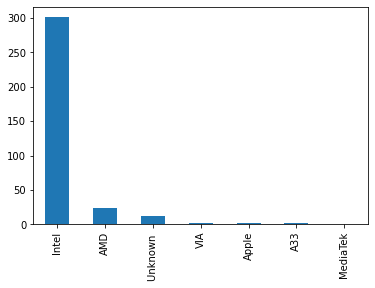

In [30]:
df['CPU manufacturer'].value_counts().plot(kind='bar')

Intel really dominates the market

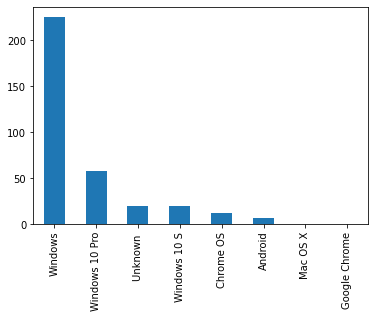

In [31]:
df['Operating System'].value_counts().plot(kind='bar')

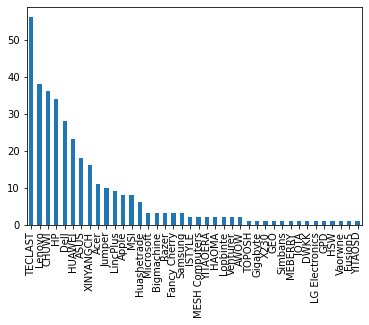

In [32]:
df['Brand'].value_counts().plot(kind='bar')

More variety by brand

## Analysis

In [33]:
df = pd.get_dummies(df)

In [34]:
X = df.drop('Price',axis = 1)
y = df['Price']

In [35]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)

In [36]:
grid_models = gsc.fit(X, y)
best_params = grid_models.best_params_

In [37]:
forest = RandomForestRegressor(max_depth=best_params["max_depth"],
                      n_estimators=best_params["n_estimators"],
                      random_state=1, 
                      verbose=False)

In [38]:
cross_val_score(forest, X, y, cv=10, scoring='neg_mean_absolute_error')


array([ -64.18351732,  -91.7876381 ,  -83.64802502,  -64.72479026,
       -129.39052997, -137.51479618, -127.9545474 , -114.33438623,
        -74.61459229, -188.82409718])